In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from notion.client import NotionClient
from notion.block import ImageBlock
from matplotlib_venn import venn2
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
def bar_plot(data, x_col, y_col, order, hue_col=None, hue_order=None):
    # Create the bar plot
    ax = sns.barplot(
        x=x_col, y=y_col, hue=hue_col,
        order=order,
        hue_order=hue_order,
        data=data)
    
    # Return the figure object and axis
    return plt.gcf(), ax

def set_labels(fig, axes, plot_title, ytick_marks=None, ytick_labels=None):
    #These are the values on each bar
    # Plot the daily lines
    if ytick_marks is not None:
        for day in ytick_marks:
            axes.axhline(day, ls='--')
            axes.set_yticks(ytick_marks)
            axes.set_yticklabels(ytick_labels)
    for container in axes.containers:
        axes.bar_label(container)

    fig.suptitle(plot_title, fontsize=16, x=0.55)



    
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper", font_scale=6)
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif', font_scale=1.2)
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
def color_bars(axes, colors):
    # Iterate over each subplot
    for i in range(3):

        # Pull out the dark and light colors for
        # the current subplot
        dark_color = colors[i*2]
        light_color = colors[i*2 + 1]

        # These are the patches (matplotlib's terminology
        # for the rectangles corresponding to the bars)
        p1, p2 = axes[i].patches

        # The first bar gets the dark color
        p1.set_color(dark_color)
        
        # The second bar gets the light color, plus
        # hatch marks int he dark color
        p2.set_color(light_color)
        p2.set_edgecolor(dark_color)
        p2.set_hatch('////')
        
def set_size(fig, sizex, sizey):
    fig.set_size_inches(sizex, sizey)
    plt.tight_layout()

In [7]:
client = NotionClient(token_v2="139b8c6d1d018eae304c390a00bbb6b0ef267141f2b0499d5c25114894b7bbfbff39b3d459ef7e06c3c2dddfa43f644d3d027855117142112274dd4a9adeea32dd015dfba4287e8faa4c7f771931")


In [21]:
idlist=[]
page = client.get_block(client.get_block(client.get_block('1686582a89564cb7acdd30c67518d799').children[-1].id.replace('-','')).children[-1].id.replace('-',''))
for child in page.children:
    try:
        idlist.append(child.collection.id.replace("-", ""))
    except:
        pass
idlist

['6be263db3b7f496b824154c5ddd7415e', '26b90c67fe6f4754a7647926eb958f92']

In [22]:
dp = client.get_collection(idlist[1])
des_plan=pd.DataFrame([(row.Name, row.WOL_tags, row.Duration, row.backlog) for row in dp.get_rows()],
             columns=['Name', 'WOL_tags', 'Duration', 'Backlog'])
des_plan = des_plan[~des_plan.Backlog]
des_plan['Duration'] = des_plan.apply(lambda x: np.round(x.Duration/len(x.WOL_tags),2), axis=1)
des_plan = des_plan.explode('WOL_tags')
des_plan_summary=des_plan.groupby('WOL_tags')['Duration'].sum().reset_index()
des_plan_summary['kind']='designed'
des_plan_summary['Duration(%)']=np.round(100*des_plan_summary['Duration']/(des_plan_summary.groupby('WOL_tags')['Duration'].sum().sum()),2)

print('Designed plan: ', des_plan.groupby('WOL_tags')['Duration'].sum().sum())



ep = client.get_collection(idlist[0])
exec_plan=pd.DataFrame([(row.Name, row.WOL_tags, row.Date.start, row.Date.end, row.Comment) for row in ep.get_rows(limit=1000)],
             columns=['Name', 'WOL_tags', 'Start', 'End', 'Comment'])

exec_plan['Duration'] = exec_plan.apply(lambda x: np.round((x.End - x.Start).total_seconds()/(3600*len(x.WOL_tags)),2), axis=1)
exec_plan = exec_plan.explode('WOL_tags')
exec_plan_summary = exec_plan.groupby('WOL_tags')['Duration'].sum().reset_index()
exec_plan_summary['kind']='executed'
exec_plan_summary['Duration(%)']=np.round(100*exec_plan_summary['Duration']/(exec_plan_summary.groupby('WOL_tags')['Duration'].sum().sum()),2)

print('Executed plan: ', exec_plan.groupby('WOL_tags')['Duration'].sum().sum())

Designed plan:  162.0
Executed plan:  32.25


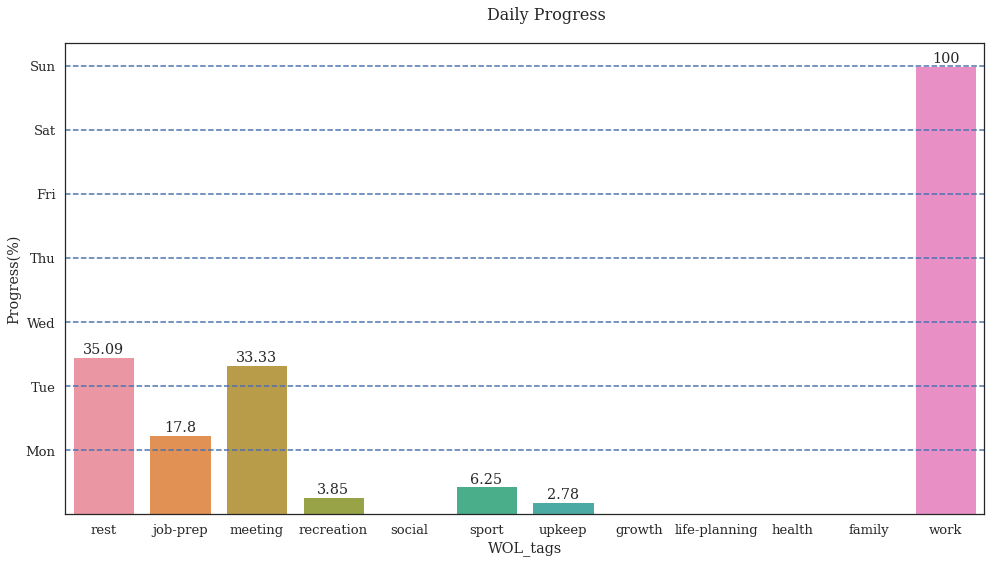

In [23]:
s=pd.merge(des_plan_summary, exec_plan_summary, on='WOL_tags', how='outer').apply(lambda x: (x['WOL_tags'], np.round(100*x['Duration_y']/x['Duration_x'],2)), axis=1)
progress_df = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T.rename(columns={0:'WOL_tags',1:'Progress(%)'})
ytick_marks = np.arange(100/7,100+100/7,100/7)
ytick_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sizex, sizey = 14,8
x_col='WOL_tags'
y_col='Progress(%)'
plot_title = 'Daily Progress'
order= des_plan_summary.sort_values('Duration', ascending=False).WOL_tags.tolist()
set_style()
fig, axes = bar_plot(progress_df, x_col, y_col, order)
set_labels(fig, axes, plot_title, ytick_marks, ytick_labels);
#color_bars(axes, get_colors())
set_size(fig,sizex, sizey)
fig.savefig('/Users/hparsa/Desktop/progress.jpeg')

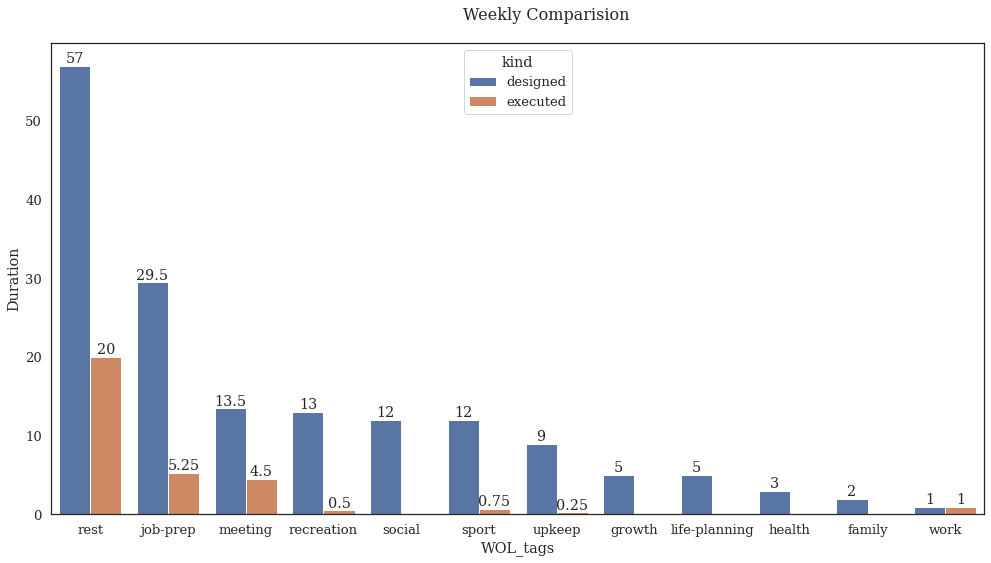

In [24]:
sizex, sizey = 14,8
x_col='WOL_tags'
y_col='Duration'
hue_col='kind'
plot_title = 'Weekly Comparision'
exec_order = exec_plan_summary.sort_values('Duration', ascending=False).WOL_tags.tolist()
order= des_plan_summary.sort_values('Duration', ascending=False).WOL_tags.tolist() + [x for x in exec_order if x not in order]
hue_order=['designed', 'executed']
set_style()
fig, axes = bar_plot(pd.concat([des_plan_summary, exec_plan_summary], axis=0), x_col, y_col, order, hue_col, hue_order)
set_labels(fig, axes, plot_title);
#color_bars(axes, get_colors())
set_size(fig,sizex, sizey)
fig.savefig('/Users/hparsa/Desktop/compare.jpeg')

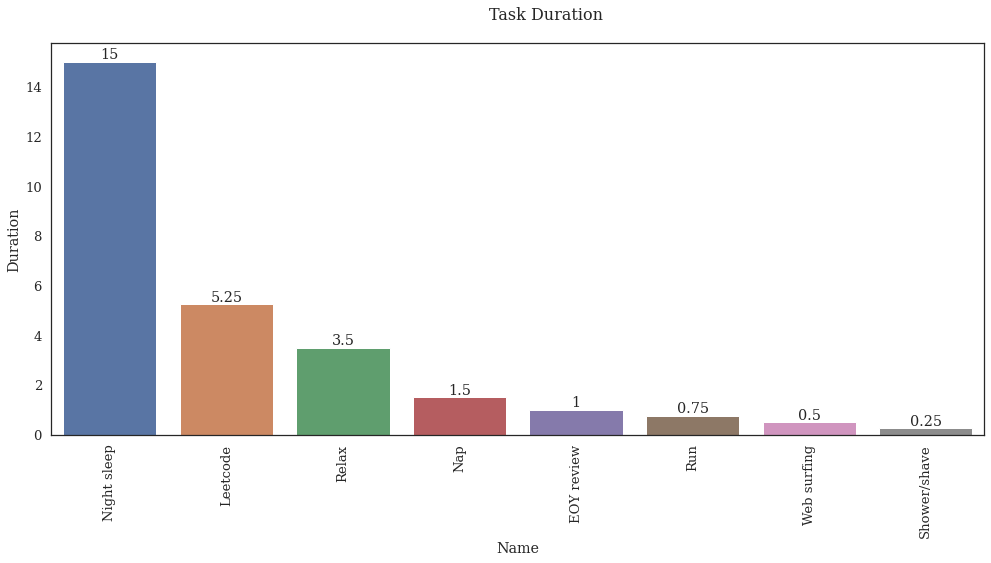

In [25]:
task_duration = exec_plan[exec_plan.WOL_tags.isin(['job-prep', 'recreation', 'sport', 'work', 'growth', 'social', 'upkeep', 'rest'])].groupby('Name').sum('Duration').reset_index()

sizex, sizey = 14,8
x_col='Name'
y_col='Duration'
plot_title = 'Task Duration'
order= task_duration.sort_values('Duration', ascending=False).Name.tolist()
fig, axes = bar_plot(task_duration, x_col, y_col,order)
plt.xticks(rotation=90)
set_labels(fig, axes, plot_title);
set_size(fig,sizex, sizey)
fig.savefig('/Users/hparsa/Desktop/task_duration.jpeg')

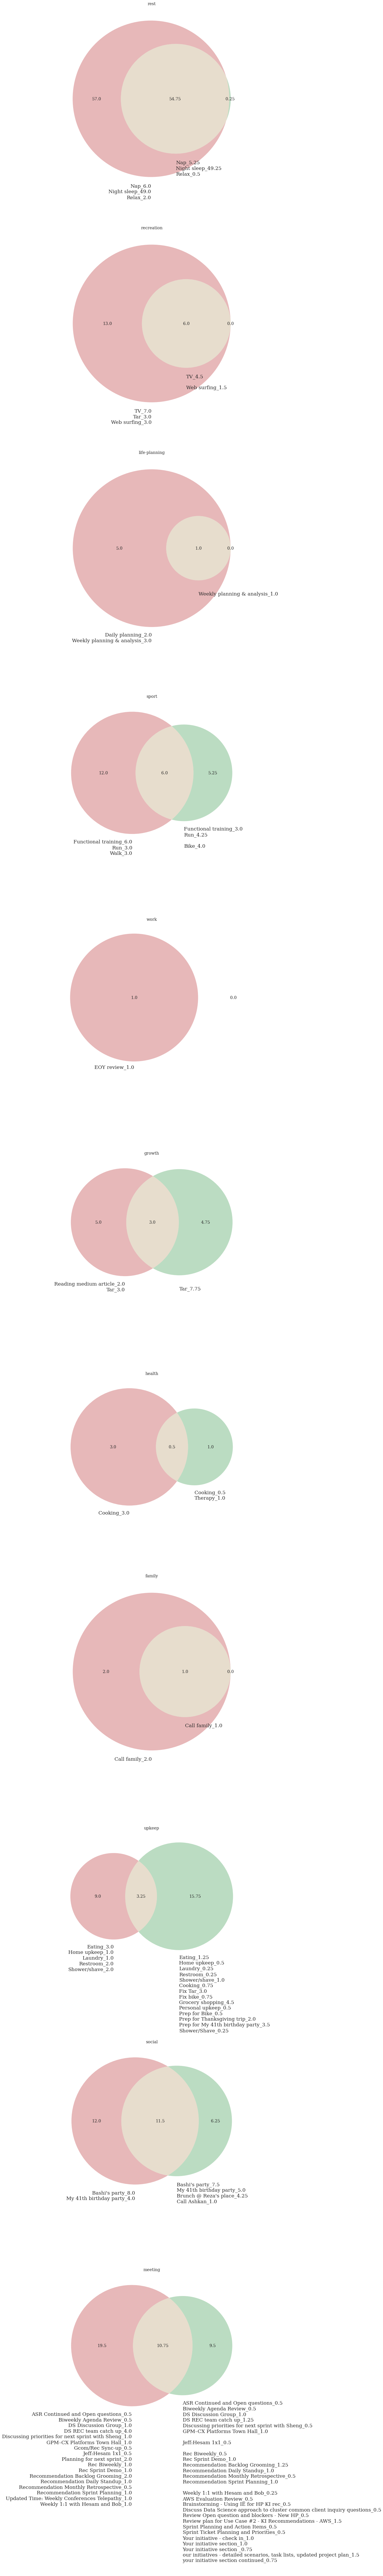

In [15]:
tag_list=exec_plan['WOL_tags'].unique()
tag_list=['rest', 'recreation', 'life-planning', 'sport', 'work', 'growth', 'health', 'family', 'upkeep', 'social', 'meeting']
plt.close()
figure, axes = plt.subplots(len(tag_list))
set_size(figure, 10, 120)
#figure.set_size_inches(10, 120)
for i,x in enumerate(tag_list):
    ep_df = exec_plan[exec_plan['WOL_tags']==x].groupby('Name')['Duration'].sum().reset_index().rename(columns={'Duration':'executed'})
    dp_df = des_plan[des_plan['WOL_tags']==x].groupby('Name')['Duration'].sum().reset_index().rename(columns={'Duration':'designed'})
    df=pd.merge(dp_df, ep_df, on='Name', how='outer').fillna(0)
    df['overlap'] = df.apply(lambda x: min(x.designed, x.executed), axis=1)
    v=venn2(subsets = (np.round(df.designed.sum(),2), np.round(df.executed.sum() - df.overlap.sum(),2), np.round(df.overlap.sum(),2)),
          set_labels = (('\n'.join(df.apply(lambda x: '_'.join([x.Name, str(x.designed)]) if (x.designed>0) else '', axis=1).to_list())),
                        ('\n'.join(df.apply(lambda x: '_'.join([x.Name, str(x.executed)]) if (x.executed>0) else '', axis=1).to_list()))
                        ), ax=axes[i]);
    #v.get_patch_by_id('100').set_color('green')
    #v.get_patch_by_id('01').set_color('red')
    axes[i].title.set_text(x)
    #display(df)
plt.show()
figure.savefig('/Users/hparsa/Desktop/venn.jpeg')

In [16]:
image = page.children.add_new(ImageBlock, width=400)
image.upload_file('/Users/hparsa/Desktop/task_duration.jpeg')

In [17]:
#client.get_block(page.children[-1].id).remove()
image = page.children.add_new(ImageBlock, width=400)
image.upload_file('/Users/hparsa/Desktop/compare.jpeg')

In [18]:
image = page.children.add_new(ImageBlock, width=300)
image.upload_file('/Users/hparsa/Desktop/progress.jpeg')

In [19]:
image = page.children.add_new(ImageBlock, width=400)
image.upload_file('/Users/hparsa/Desktop/venn.jpeg')

In [72]:
#client.get_block(page.children[-1].id).remove()